In [ ]:
! pip install --quiet fuzzywuzzy
! pip install --quiet nltk
! pip install --quiet diskcache
! pip install --quiet python-Levenshtein
! pip install --quiet lightgbm
! pip install -e 'git://github.com/nandanrao/embed-software.git#egg=embed_software'

In [1]:
import nltk 
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...


[nltk_data]   Package wordnet is already up-to-date!


True

In [168]:
%load_ext autoreload 
%autoreload 2

import pandas as pd
import numpy as np
import re
import attr

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from scipy.sparse import vstack 

from validation.data import indeed_test_data, dot_train_data, get_soc_n
from embed_software.preprocess import *
from embed_software.utils import *
from validation.title_matching import layered_matcher, title_matcher, punct_lookup, exact_matcher
from validation.dot_data import LemmaTokenizer, get_dictionary

pd.set_option('max_colwidth',50)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
class PreEmbeddedVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, embed_path, model, lim, dims):
        self.embed_path = embed_path
        self.model = model
        self.lim = lim
        self.dims = dims
        
    def fit(self, X, y=None):
        self.fit_X = X
        self.embeddings = get_embeddings(self.embed_path, self.lim, self.dims)
        return self
    
    def transform(self, X):
        # Our test set is pre-embedded, but our train set not!
        # This should simply be a cached embedding...? 
        if self.fit_X is X:
            return embed_docs(self.model, '\n'.join(X))
        else:
            return self.embeddings[X.index] 

In [279]:
SAMPLE_SIZE = 100000
SOC_LEVEL = 2

In [280]:
X_train, y_train = dot_train_data(SOC_LEVEL)
# X_test, y_test, ids = indeed_test_data('us-everything.csv', SAMPLE_SIZE, SOC_LEVEL)

In [281]:
vecs = PreEmbeddedVectorizer('../ss_embeds/ss_100_us_b.txt', '../ss_models/sentencespace_us', SAMPLE_SIZE, 100).fit_transform(X_train)
dot_dict = get_dictionary('', SOC_LEVEL)
vecs = vecs[:dot_dict.shape[0]]
y_train = y_train[:dot_dict.shape[0]]

In [ ]:
desc = 'desc_soc{}'.format(SOC_LEVEL)

lookup = dot_dict.groupby('soc').apply(lambda df: df.head(1))[['soc', desc]]
y_desc = pd.DataFrame({ 'soc': y_train}).merge(lookup, how='left', on='soc')
labels = y_desc[desc]

In [359]:
occupations = np.random.choice(y_desc[desc].unique(), size=6, replace=False)
idx = y_desc[y_desc[desc].isin(occupations)].groupby(desc).apply(lambda df: df.sample(100)).index.levels[1]

In [360]:
from sklearn.manifold import MDS, Isomap, TSNE
two = MDS().fit_transform(vecs[idx])

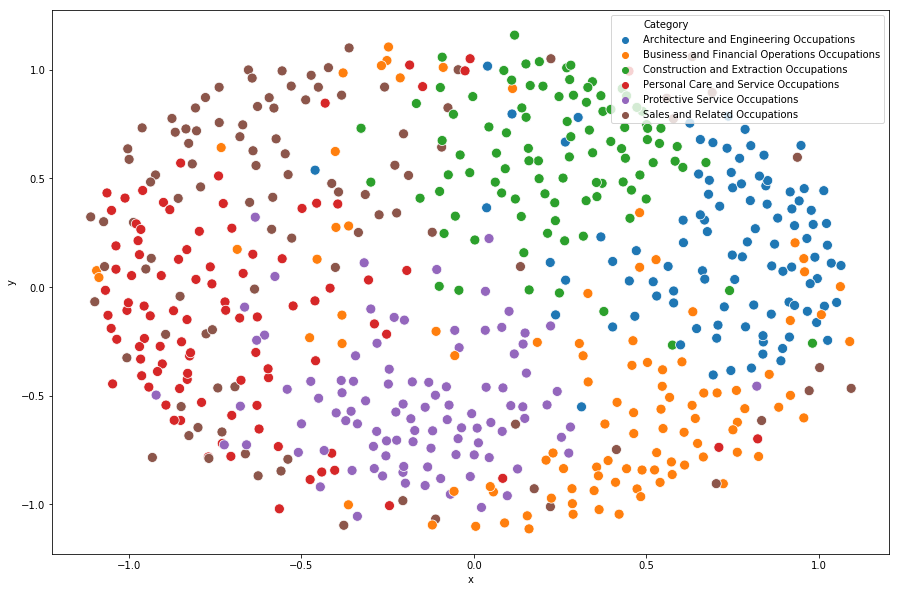

In [372]:
import seaborn as sns

df = pd.DataFrame(two, columns = ['x', 'y']).assign(Category = labels[idx].astype('category').values)
ax = sns.scatterplot(x = 'x', y = 'y', hue = 'Category', data=df, s=100)
ax.get_figure().savefig('figures/MDS-soc2.png')

In [6]:
class VectorizedData():
    def __init__(self, vectorizer, splits, n_jobs):
        self.vectorizer = vectorizer
        self.X_train, self.X_test, self.y_train, self.y_test = splits
        self.n_jobs = n_jobs
        
    def vectorize(self):
        self.V_train = self.vectorizer.fit_transform(self.X_train)
        self.V_test = self.vectorizer.transform(self.X_test)
        
    def top_n_results(self, search, n=5):
        res = search.cv_results_
        tops = np.flip(np.argsort(res['mean_test_score']), 0)[:5]
        scores = np.array(res['mean_test_score'])[tops]
        params = pd.DataFrame(np.array(res['params'])[tops].tolist())
        return params.assign(score = scores)

    def run_search(self, model, param_grid):
        y = pd.concat([self.y_train, self.y_test])
        try:
            X = np.concatenate([self.V_train, self.V_test])
        except ValueError:
            X = vstack([self.V_train, self.V_test]) 
        cv = [(np.arange(0, self.X_train.shape[0]), np.arange(self.X_train.shape[0], X.shape[0]))]
        search = GridSearchCV(model, param_grid=param_grid, cv = cv, n_jobs=8)
        search.fit(X, y)
        return self.top_n_results(search)

# Hyperparameter Search

In [7]:
splits = [X_train, X_test, y_train, y_test]

ss_embedder = PreEmbeddedVectorizer('../ss_embeds/ss_100_us.txt', '../ss_models/sentencespace', SAMPLE_SIZE)
embedded = VectorizedData(ss_embedder,splits, 8)
embedded.vectorize()

tfidf = TfidfVectorizer()
bow = VectorizedData(tfidf, splits, 8)
bow.vectorize()

In [ ]:
param_grid = {
    'num_leaves': [9, 31],
    'max_depth': [-1, 2],
    'n_estimators': [100, 400]
}

embedded.run_search(LGBMClassifier(), param_grid)

In [8]:
param_grid = {
    'C': [1.0, 5.0, 10.0, 20.0]
}

print(embedded.run_search(SVC(), param_grid))

      C     score
0  20.0  0.525174
1  10.0  0.519633
2   5.0  0.502294
3   1.0  0.308884


In [9]:
param_grid = {
    'C': [1.0, 5.0, 10.0],
    'multi_class': ['multinomial', 'ovr']
}

print(embedded.run_search(LogisticRegression(solver='newton-cg'), param_grid))

      C  multi_class     score
0   5.0  multinomial  0.537747
1  10.0  multinomial  0.537270
2   1.0  multinomial  0.532444
3  10.0          ovr  0.518620
4   5.0          ovr  0.517786


In [10]:
param_grid = {
    'C': [1.0, 5.0, 10.0],
    'multi_class': ['multinomial', 'ovr']
}

print(bow.run_search(LogisticRegression(solver='newton-cg'), param_grid))

      C  multi_class     score
0   5.0          ovr  0.489900
1  10.0          ovr  0.483287
2   5.0  multinomial  0.475958
3   1.0          ovr  0.469761
4   1.0  multinomial  0.469582


# COMPARE MODELS

In [22]:
models = [
    Pipeline([('tfidf', TfidfVectorizer()),
              ('lr', LogisticRegression(C=5., solver='newton-cg', multi_class="ovr", n_jobs=-1))]),
    Pipeline([('embed', PreEmbeddedVectorizer('../ss_embeds/ss_100_us_b.txt', '../ss_models/sentencespace_us', SAMPLE_SIZE, 100)),
             ('lr', LogisticRegression(C=5., solver='newton-cg', multi_class="multinomial", n_jobs=-1))]),
#     Pipeline([('embed', PreEmbeddedVectorizer('../ss_embeds/ss_100_us.txt', '../ss_models/sentencespace', SAMPLE_SIZE)),
#              ('knn', KNeighborsClassifier(7))]),
    Pipeline([('embed', PreEmbeddedVectorizer('../ss_embeds/ss_100_us_b.txt', '../ss_models/sentencespace_us', SAMPLE_SIZE, 100)),
             ('svc', SVC(C=20., probability=True))]),
#     Pipeline([('embed', PreEmbeddedVectorizer('../ss_embeds/ss_100_us.txt', '../ss_models/sentencespace', SAMPLE_SIZE)),
#              ('lgbm', LGBMClassifier(n_estimators=400, max_depth=2))])
]

In [23]:
@attr.s
class Predictor():
    X_train = attr.ib()
    y_train = attr.ib()
    X_test = attr.ib()

    def fn(self, m):
        return (m
                .fit(self.X_train, self.y_train)
                .predict(self.X_test))

In [24]:
p = Predictor(X_train, y_train, X_test)

from concurrent.futures import ProcessPoolExecutor as Pool

pool = Pool()
preds = pool.map(p.fn, models)

In [25]:
preds = [p for p in preds]

In [27]:
[accuracy_score(p, y_test) for p in preds]

[0.49040702886856735, 0.58729304883151034, 0.57982188751419517]

In [46]:
p = pd.DataFrame(preds).T.assign(y = y_test.values)

differ = p[p[0] != p[1]]

In [ ]:
differ[differ[0] == differ['y']].y.value_counts()

In [ ]:
print(classification_report(preds[0], y_test))

In [ ]:
print(classification_report(preds[1], y_test))

# Confusion Matrices

In [ ]:
def print_confusion_matrices(models, preds, SOC_LEVEL):
    dot_dict = get_dictionary('', SOC_LEVEL)
    model_names = ['-'.join(m.named_steps.keys()) for m in models]
    un = dot_dict.groupby('soc').apply(lambda df: df.head(1))
    category_names = un['desc_soc{}'.format(SOC_LEVEL)]
    for name,p in zip(model_names, preds):
        df = pd.DataFrame(confusion_matrix(y_test, p, un.soc), 
                          index=category_names, 
                          columns=category_names)
        filename = 'confusion-matrices/soc-{}/{}.csv'.format(SOC_LEVEL, name)
        df.to_csv(filename, index=False)

# Making Predictions

In [11]:
def make_predictions_df(df, preds):
    key = 'predicted_soc{}'.format(SOC_LEVEL)
    desc = 'desc_soc{}'.format(SOC_LEVEL)
    dot_dict = get_dictionary('', SOC_LEVEL)
    dd = dot_dict.groupby('soc').first()[desc].reset_index()
    found = (pd.DataFrame({key: preds})
             .merge(dd, how='left', left_on=key, right_on='soc')
             .drop('soc', 1))
    return (pd.concat([df, found], 1)
            .rename(columns = {'content': 'description'}))

def print_predictions(model, infile, outpath, SOC_LEVEL):
    X_train, y_train = dot_train_data(SOC_LEVEL)
    df = pd.read_csv(infile)
    all_preds = model.fit(X_train, y_train).predict(df.content)
    filename = '{}/us-soc{}-predictions.csv'.format(outpath, SOC_LEVEL)
    make_predictions_df(df, all_preds).to_csv(filename, index=False)    

In [216]:
df = pd.read_csv('confusion-matrices/soc-3/embed-lr.csv')

In [217]:
micro(df)

(0.41054341938978156, 0.40667660208643813)

In [218]:
macro(df)

(0.19705964432013226, 0.19270635975295053)

In [225]:
macro(df, 'weighted')

(0.46063510164916216, 0.40667660208643819)